In [81]:
# Our code will generate data, visualization and model checkpoints, they will be persisted to disk in this folder
ARTIFACTS_FOLDER = "./artifacts"

In [82]:
import pdb
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R
from collections import defaultdict

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [83]:
# !ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_images images
# !ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_maps maps
# !ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_lidar lidar
base_dir = '../data/lyft/lyft_trainval/'

In [84]:
level5data = LyftDataset(data_path=base_dir, json_path=f'{base_dir}/v1.0-trainval', verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 6.3 seconds.
Reverse indexing ...
Done reverse indexing in 2.3 seconds.


In [85]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

Preparing a dataframe of scenes, with one scene per row

In [86]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]

entries = []

for start_time, record in sorted(records): # sorted acc to timestamp
#     pdb.set_trace()
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000
    token = record['token']
    name = record['name'] # 'host-a007-lidar0-1230485630199365106-1230485655099030186'
    date = datetime.utcfromtimestamp(start_time) # datetime.datetime(2019, 1, 2, 17, 33, 50, 301987)
    host = "-".join(record['name'].split("-")[:2]) # 'host-a007'
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [87]:
df.head()

,host,scene_name,date,scene_token,first_sample_token
0,host-a007,host-a007-lidar0-1230485630199365106-123048565...,2019-01-02 17:33:50.301987,473093b48a7cb78d05e36245fd2dbd12d66ded7dab1ecb...,c7f7de87ec90c8993d4e7d5463208d2aa9f5ecde671960...
1,host-a007,host-a007-lidar0-1230672860198383106-123067288...,2019-01-04 21:34:20.301189,c62b89d6ae60528c00b8a520bfa16799147f5c2dccbe1e...,07889e50d51717e829cbcb4800e6cb2ce08bdabe92440c...
2,host-a007,host-a007-lidar0-1230936221299185986-123093624...,2019-01-07 22:43:41.402021,694dc7b4629151745d3e1b228b1d6653b0fc1ded12aa8d...,83ce1da2c4b37ca88a102928f01512acf8f55ac7207d04...
3,host-a007,host-a007-lidar0-1231093036199514746-123109306...,2019-01-09 18:17:16.302257,8ed3a2f8cf6e01e0d2c0df7db77839f468ed2aa48b6511...,dddda3940f002b0fa6c495a5ad6d5c4a4c8253aa5ed189...
4,host-a009,host-a009-lidar0-1231200854198312986-123120087...,2019-01-11 00:14:14.301261,a05a48966fbc46666be116a79222374c6c79e6fa930c2f...,8990abea0a146b047a04bc6ed303b16cb1c62cca49bf58...


In [88]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
host-a101    20
host-a102    12
Name: scene_token, dtype: int64


### Train/Validation split
Let's split the data by car to get a validation set.
Alternatively we could consider doing it by scenes, date, or completely randomly.

In [89]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

print(len(train_df), len(validation_df), "train/validation split scene counts")

140 40 train/validation split scene counts


## B. Creating input and targets

Let's load the first sample in the train set. We can use that to test the functions we'll define next that transform the data to the format we want to input into the model we are training.

In [90]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)
sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False) # 4x4

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False) # 4x4

In [91]:
# for sensor, sensor_token in sample['data'].items():
#     data = level5data.get('sample_data', sensor_token) 
#     print(data['ego_pose_token'])
#     ego_pose = level5data.get("ego_pose", data["ego_pose_token"])
#     print(ego_pose)

Each sensor has it's own ego pose token, though the pose parameters vary only little

In [92]:
# for sensor, sensor_token in sample['data'].items():
#     data = level5data.get('sample_data', sensor_token) 
# #     print(data['calibrated_sensor_token'])
#     calibrated_sensor = level5data.get("calibrated_sensor", data["calibrated_sensor_token"])
#     print(calibrated_sensor)

each sensor has its own calibration params, quite diff from other sensors

In [93]:
q = Quaternion(ego_pose['rotation'])

In [94]:
ego_pose['rotation']

[0.16443143502531854,
 0.02522225267574294,
 0.0117456840556274,
 0.9859960345009208]

In [95]:
q.rotation_matrix

array([[-0.94465228, -0.32366498,  0.0536008 ],
       [ 0.32484999, -0.94564868,  0.01486773],
       [ 0.04587536,  0.03145706,  0.99845175]])

In [96]:
q.transformation_matrix

array([[-0.94465228, -0.32366498,  0.0536008 ,  0.        ],
       [ 0.32484999, -0.94564868,  0.01486773,  0.        ],
       [ 0.04587536,  0.03145706,  0.99845175,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [97]:
np.transpose(np.array(ego_pose['translation'])), np.array(ego_pose['translation'])

(array([ 871.90987674, 2567.76954476,  -21.79129628]),
 array([ 871.90987674, 2567.76954476,  -21.79129628]))

In [98]:
np.transpose(np.array(ego_pose['translation'])).shape, np.array(ego_pose['translation']).shape, np.array([0, 0, 0]).shape

((3,), (3,), (3,))

In [99]:
translation = ego_pose['translation']
tm = np.eye(4)
tm[:3, :3] = q.rotation_matrix
tm[:3, 3] = np.array(translation)

In [100]:
translation

[871.9098767426335, 2567.7695447600618, -21.791296281900813]

In [101]:
tm

array([[-9.44652282e-01, -3.23664981e-01,  5.36008016e-02,
         8.71909877e+02],
       [ 3.24849991e-01, -9.45648684e-01,  1.48677334e-02,
         2.56776954e+03],
       [ 4.58753629e-02,  3.14570582e-02,  9.98451754e-01,
        -2.17912963e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

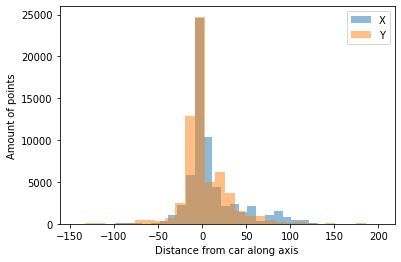

In [102]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

# The lidar pointcloud is defined in the sensor's reference frame.
# We want it in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor)

# A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

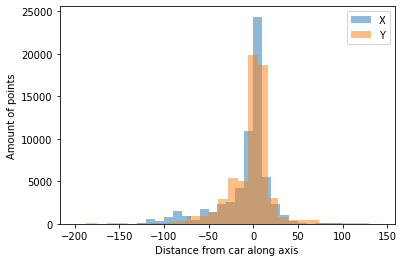

In [103]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [104]:
lidar_pointcloud.points.shape

(4, 61908)

As input for our network we voxelize the LIDAR points. That means that we go from a list of coordinates of points, to a X by Y by Z space.

In [105]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

# Let's try it with some example values
tm = create_transformation_matrix_to_voxel_space(shape=(100,100,4), voxel_size=(0.5,0.5,0.5), offset=(0,0,0.5))
points = np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype=np.float32)
p = transform_points(points, tm)
print(p, p.shape)

[[70. 70. 50. 50. 50.]
 [70. 60. 50. 50. 50.]
 [ 3.  3.  3.  7.  3.]] (3, 5)


In [106]:
points

array([[10., 10.,  0.,  0.,  0.],
       [10.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  0.]], dtype=float32)

In [107]:
tm

array([[ 2.,  0.,  0., 50.],
       [ 0.,  2.,  0., 50.],
       [ 0.,  0.,  2.,  3.],
       [ 0.,  0.,  0.,  1.]])

In [108]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)

# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = normalize_voxel_intensities(bev)

In [109]:
bev.shape

(336, 336, 3)

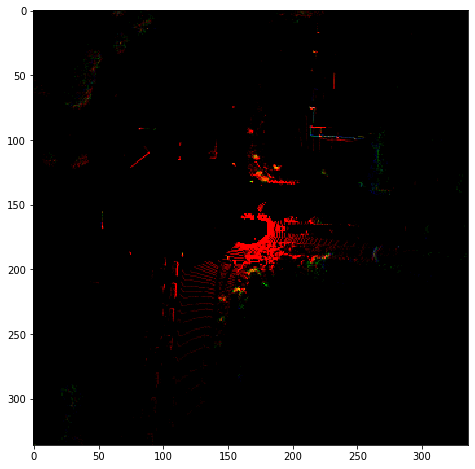

In [110]:
plt.figure(figsize=(16,8))
plt.imshow(bev)
plt.show()

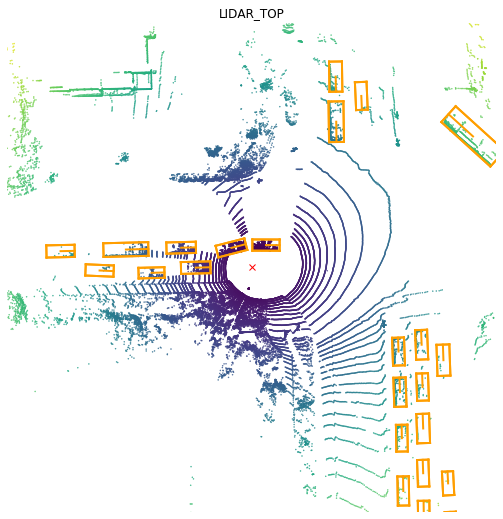

In [111]:
level5data.render_sample_data(sample_lidar_token)

Above is an example of what the input for our network will look like. It's a top-down projection of the world around the car (the car faces to the right in the image). **he height of the lidar points are separated into three bins, which visualized like this these are the RGB channels of the image.**

In [112]:
bev.shape[:3]

(336, 336, 3)

In [113]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor


In [114]:

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)


        

In [115]:
boxes = level5data.get_boxes(sample_lidar_token)

In [116]:
boxes[0]

label: nan, score: nan, xyz: [862.78, 2630.27, -19.50], wlh: [2.04, 4.96, 1.56], rot axis: [0.00, 0.00, 1.00], ang(degrees): -107.99, ang(rad): -1.88, vel: nan, nan, nan, name: car, token: 2fe740def816eed5c8d4f02e689b2bd7a6d1897fc282873b2053e81620ef091c

In [117]:
# target_im = np.zeros(bev.shape[:3], dtype=np.uint8)
move_boxes_to_car_space(boxes, ego_pose)
boxes[0]

label: nan, score: nan, xyz: [29.03, -56.07, 2.73], wlh: [2.04, 4.96, 1.56], rot axis: [0.01, 0.04, 1.00], ang(degrees): 90.99, ang(rad): 1.59, vel: nan, nan, nan, name: car, token: 2fe740def816eed5c8d4f02e689b2bd7a6d1897fc282873b2053e81620ef091c

In [118]:
boxes[0].name

'car'

In [119]:
scale_boxes(boxes, 0.8)

In [120]:
boxes[0]

label: nan, score: nan, xyz: [29.03, -56.07, 2.73], wlh: [1.63, 3.97, 1.25], rot axis: [0.01, 0.04, 1.00], ang(degrees): 90.99, ang(rad): 1.59, vel: nan, nan, nan, name: car, token: 2fe740def816eed5c8d4f02e689b2bd7a6d1897fc282873b2053e81620ef091c

In [121]:
boxes[0].corners()

array([[ 28.21181516,  29.84425343,  29.78696428,  28.15452601,
         28.27988935,  29.91232763,  29.85503847,  28.2226002 ],
       [-54.08485544, -54.05914981, -54.09843338, -54.12413902,
        -58.04880164, -58.02309601, -58.06237958, -58.08808521],
       [  3.33054439,   3.25472968,   2.00786313,   2.08367784,
          3.45230406,   3.37648936,   2.12962281,   2.20543751]])

In [122]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
points = lidar_pointcloud.points

In [123]:
points.shape

(4, 61908)

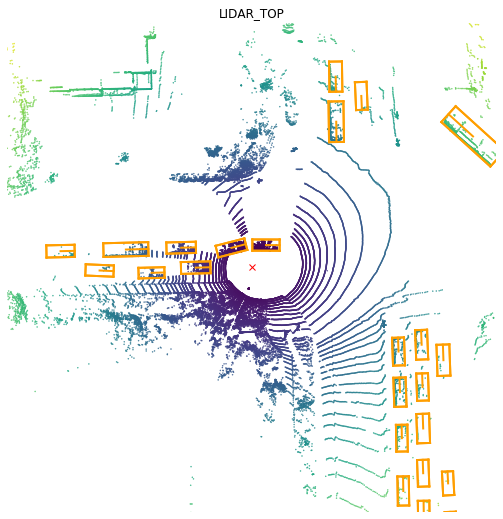

In [124]:
level5data.render_sample_data(sample_lidar_token)

In [125]:
def get_color(category_name):
    """Provides the default colors based on the category names.
    This method works for the general Lyft Dataset categories, as well as the Lyft Dataset detection categories.

    Args:
        category_name:

    Returns:

    """
    if "bicycle" in category_name or "motorcycle" in category_name:
        return 255, 61, 99  # Red
    elif "vehicle" in category_name or category_name in ["bus", "car", "construction_vehicle", "trailer", "truck"]:
        return 255, 158, 0  # Orange
    elif "pedestrian" in category_name:
        return 0, 0, 230  # Blue
    elif "cone" in category_name or "barrier" in category_name:
        return 0, 0, 0  # Black
    else:
        return 255, 0, 255  # Magenta


In [164]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
from lyft_dataset_sdk.lyftdataset import *

# Get sensor modality.
def get_lidar_points(
        lidar_token,
        num_sweeps = 1,
    ):
    sd_record = level5data.get("sample_data", lidar_token)
    sensor_modality = sd_record["sensor_modality"]
    # Get aggregated point cloud in lidar frame.
    sample_rec = level5data.get("sample", sd_record["sample_token"])
    chan = sd_record["channel"]
    ref_chan = "LIDAR_TOP"
    pc, times = LidarPointCloud.from_file_multisweep(
        level5data, sample_rec, chan, ref_chan, num_sweeps=num_sweeps
    )
    # Compute transformation matrices for lidar point cloud
    cs_record = level5data.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
    pose_record = level5data.get("ego_pose", sd_record["ego_pose_token"])
    vehicle_from_sensor = np.eye(4)
    vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
    vehicle_from_sensor[:3, 3] = cs_record["translation"]

    ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
    # what is this thing doing?
    rot_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
    )
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle
    points = view_points(
        pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
    )
    return points

In [165]:
def plot_box(box, axis, view, colors, normalize=False, linewidth=2.0):
    corners = view_points(box.corners(), view, normalize=normalize)#
    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], [prev[2], corner[2]], color=color, linewidth=linewidth)
            prev = corner

    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            [corners.T[i][2], corners.T[i + 4][2]],
            color=colors[2],
            linewidth=linewidth,
        )

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0]) #4x3
    draw_rect(corners.T[4:], colors[1])

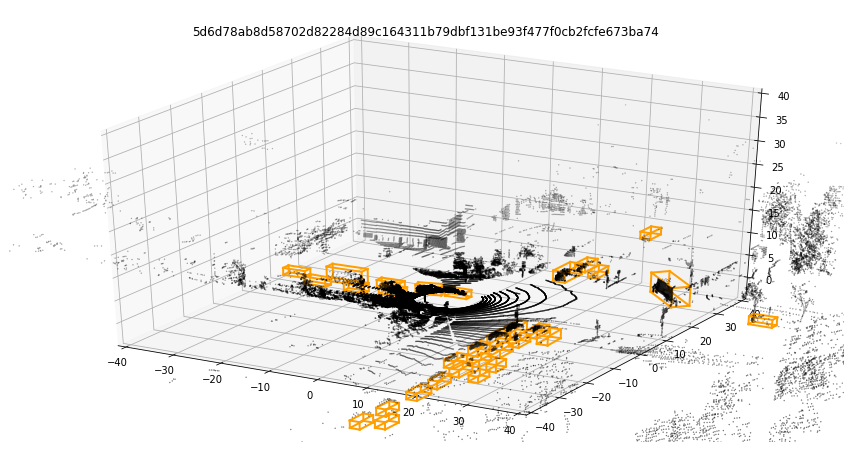

In [166]:
lidar_token = lidar_data['token']
points = get_lidar_points(lidar_token) 
# Get boxes in lidar frame.
_, boxes, _ = level5data.get_sample_data(
    lidar_token, flat_vehicle_coordinates=True
)
#flat_vehicle_coordinates: Instead of current sensor's coordinate frame, use vehicle frame which is aligned to z-plane in world
axes = [0,1,2]
axes_limits = [
    [-40, 40], # X axis range
    [-40, 40], # Y axis range
    [-4, 40]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']
axes_limit = 40
f2 = plt.figure(figsize=(15, 8))
ax = f2.add_subplot(111, projection='3d')                    
c = [1] * len(points[0])
ax.scatter(*points, s=0.1, c=c, cmap='gray')
for box in boxes:
    c = np.array(get_color(box.name)) / 255.0
    plot_box(box, ax, view=np.eye(3), colors=(c, c, c))
ax.set_xlim3d(-40, 40)
ax.set_ylim3d(-40, 40)
ax.set_zlim3d(-4, 40)
ax.set_title(lidar_token)
plt.show()

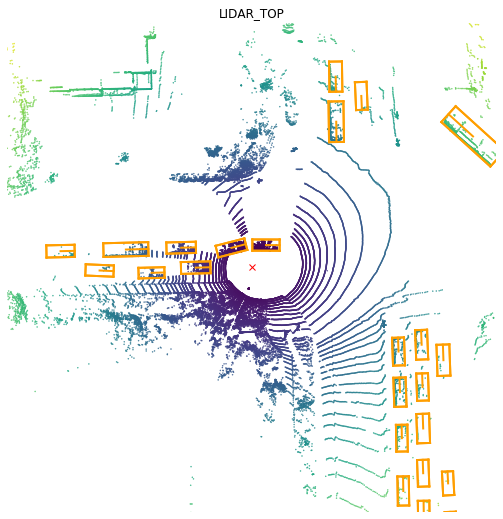

In [131]:
# Init axes.
ax = None
if ax is None:
    _, ax = plt.subplots(1, 1, figsize=(9, 9))

# Show point cloud.
# color varies according to the point's distance from the center
dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

# Show ego vehicle.
ax.plot(0, 0, "x", color="red")

# Show boxes.
if with_anns:
    for box in boxes:
        c = np.array(get_color(box.name)) / 255.0
        box.render(ax, view=np.eye(4), colors=(c, c, c))
        
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)

ax.axis("off")
ax.set_title(sd_record["channel"])
ax.set_aspect("equal")
plt.show()

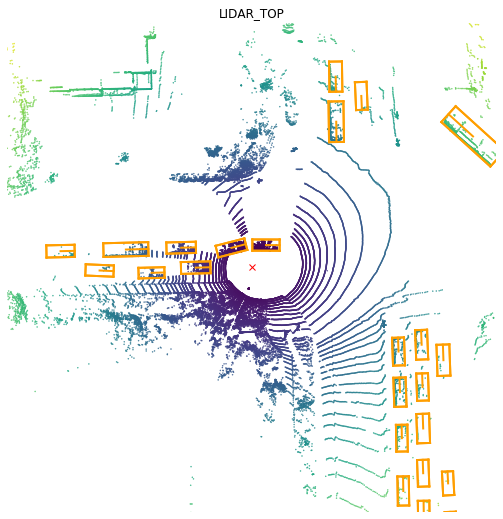

In [132]:
# Init axes.
ax = None
if ax is None:
    _, ax = plt.subplots(1, 1, figsize=(9, 9))

# Show point cloud.
# color varies according to the point's distance from the center
dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

# Show ego vehicle.
ax.plot(0, 0, "x", color="red")

# Show boxes.
if with_anns:
    for box in boxes:
        c = np.array(get_color(box.name)) / 255.0
        box.render(ax, view=np.eye(4), colors=(c, c, c))
        
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)

ax.axis("off")
ax.set_title(sd_record["channel"])
ax.set_aspect("equal")

In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = {
    'car': 'b',
    'motorcycle': 'r',
    'bicycle': 'g',
    'truck': 'c',
    'pedestrian': 'm',
    'other_vehicle': 'm',
    'animal': 'y',
    'emergency_vehicle': 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, box, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
#     vertices = vertices[axes, :]
    vertices = box.corners()
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(lidar_points, boxes, points=0.2):
    """
    Displays statistics for a single frame. Draws 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    lidar_points: lidar data points 
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    
    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    pc_frame = lidar_points[:, pc_range]
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        #         pdb.set_trace()
        ax.scatter(*pc_frame[axes, :], s=point_size, c=pc_frame[3, :], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        boxes_by_name = defaultdict(list)
        for box in boxes:
            boxes_by_name[box.name].append(box)
        print(boxes_by_name.keys(), len(boxes))

        for box, name in zip(boxes, boxes_by_name.keys()):
            points = box.corners()
            ax.scatter(points[0, :], points[1, :], points[2, :])
#             draw_box(ax, box, axes=axes, color=colors[name])

    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, '3D plot', xlim3d=(-10,30))
    plt.show()
    
#     # Draw point cloud data as plane projections
#     f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
#     draw_point_cloud(
#         ax3[0], 
#         'XZ projection (Y = 0), the car is moving in direction left to right', 
#         axes=[0, 2] # X and Z axes
#     )
#     draw_point_cloud(
#         ax3[1], 
#         'XY projection (Z = 0), the car is moving in direction left to right', 
#         axes=[0, 1] # X and Y axes
#     )
#     draw_point_cloud(
#         ax3[2], 
#         'YZ projection (X = 0), the car is moving towards the graph plane', 
#         axes=[1, 2] # Y and Z axes
#     )
#     plt.show()


dict_keys(['car', 'truck']) 31


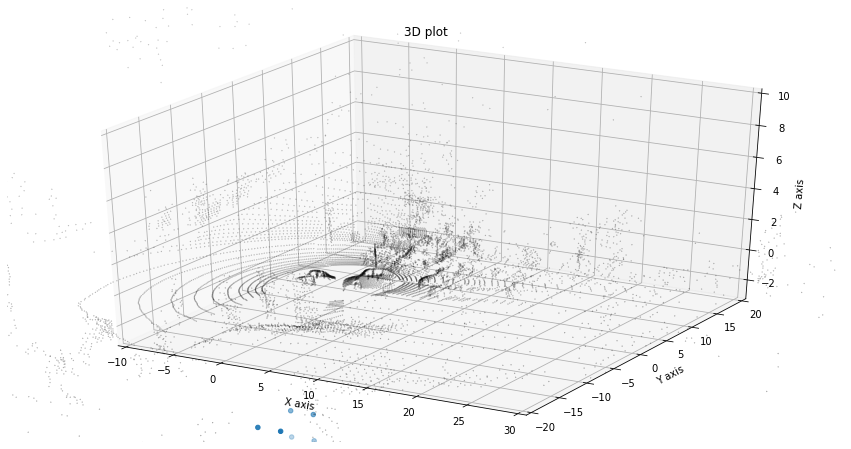

In [134]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
display_frame_statistics(lidar_pointcloud.points, boxes)

In [135]:
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
plt.show()

NameError: name 'target_im' is not defined

In [ ]:
def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    pdb.set_trace()
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

In [ ]:
truth = np.zeros([3, 100, 100])
truth[0, 35:40, 35:40] = 1
prob = np.zeros([3, 100, 100])
prob[0, 30:40, 30:40] = 1
# prob[1, 40:50, 30:40] = 1
prob[2, 30:50, 30:40] = 1
import torch
truth = torch.from_numpy(truth)
prob = torch.from_numpy(prob)

In [ ]:
metric(prob, truth)

In [ ]:
boxes[0]

In [ ]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
    
# Don't worry about it being mirrored.
visualize_lidar_of_sample(sample_token)

In [ ]:
del bev, lidar_pointcloud, boxes

In [ ]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [ ]:
# "bev" stands for birds eye view
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

In [ ]:
NUM_WORKERS = os.cpu_count() * 3

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        
        sample_token = sample["next"]

for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
    print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values

    os.makedirs(data_folder, exist_ok=True)
    
    process_func = partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = Pool(NUM_WORKERS)
    for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()
    del pool

lidar not able to load: lidar tokens
9cb04b1a4d476fd0782431764c7b55e91c6dbcbc6197c3dab3e044f13d058011

## C. Training a network to segment objects

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths)
    
im, target, sample_token = train_dataset[1]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

target_as_rgb = np.repeat(target[...,None], 3, 2)
# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

In [ ]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

We train a U-net fully convolutional neural network, we create a network that is less deep and with only half the amount of filters compared to the original U-net paper implementation. We do this to keep training and inference time low.

In [ ]:
def get_unet_model(in_channels=3, num_output_classes=2):
    model = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model


In [ ]:
def visualize_predictions(input_image, prediction, target, n_images=2, apply_softmax=True):
    """
    Takes as input 3 PyTorch tensors, plots the input image, predictions and targets.
    """
    # Only select the first n images
    prediction = prediction[:n_images]
    target = target[:n_images]
    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    if apply_softmax:
        prediction = scipy.special.softmax(prediction, axis=1)
    class_one_preds = np.hstack(1-prediction[:,0])

    target = np.hstack(target.detach().cpu().numpy())

    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0
    class_rgb[...,1] = target

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3:
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:]
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [ ]:
# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

In [ ]:
batch_size = 8
epochs = 15 # Note: We may be able to train for longer and expect better results, the reason this number is low is to keep the runtime short.

model = get_unet_model(num_output_classes=len(classes)+1)
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)

all_losses = []

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    
    epoch_losses = []
    progress_bar = tqdm_notebook(dataloader)
    
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

        if ii == 0:
            visualize_predictions(X, prediction, target)
    
    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)
    
    checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch)
    checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_filepath)
    
plt.figure(figsize=(12,12))
plt.plot(all_losses, alpha=0.75)
plt.show()

#### You can interpret the above visualizations as follows:  
There are four different visualizations stacked on top of eachother:
1. The top images have two color channels: red for predictions, green for targets. Note that red+green=yellow. In other words:  
> **Black**: True Negative  
**Green**: False Negative  
**Yellow**: True Positive  
**Red**: False Positive 
2. The input image
3. The input image (or semantic input map, not in this kernel) blended together with targets+predictions
4. The predictions thresholded at 0.5 probability.

In [ ]:
input_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_target.png")))

batch_size=16
validation_dataset = BEVImageDataset(input_filepaths, target_filepaths)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_unet_model(num_output_classes=1+len(classes))
model = model.to(device)

epoch_to_load=15
checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_filepath))

In [ ]:
progress_bar = tqdm_notebook(validation_dataloader)

targets = np.zeros((len(target_filepaths), 336, 336), dtype=np.uint8)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
predictions = np.zeros((len(target_filepaths), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

with torch.no_grad():
    model.eval()
    for ii, (X, target, batch_sample_tokens) in enumerate(progress_bar):

        offset = ii*batch_size
        targets[offset:offset+batch_size] = target.numpy()
        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)
        all_losses.append(loss.detach().cpu().numpy())
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions[offset:offset+batch_size] = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Visualize the first prediction
        if ii == 0:
            visualize_predictions(X, prediction, target, apply_softmax=False)
            
print("Mean loss:", np.mean(all_losses))

In [ ]:
#del model, class_weights, validation_dataloader, validation_dataset

In [ ]:
# Get probabilities for non-background
predictions_non_class0 = 255 - predictions[:,0]

In [ ]:
# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 255//2

for i in range(3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes[0].imshow(predictions_non_class0[i])
    axes[0].set_title("predictions")
    axes[1].imshow(predictions_non_class0[i] > background_threshold)
    axes[1].set_title("thresholded predictions")
    axes[2].imshow((targets[i] > 0).astype(np.uint8), interpolation="nearest")
    axes[2].set_title("targets")
    fig.tight_layout()
    fig.show()

In [ ]:
# We perform an opening morphological operation to filter tiny detections
# Note that this may be problematic for classes that are inherently small (e.g. pedestrians)..
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

for i, p in enumerate(tqdm(predictions_non_class0)):
    thresholded_p = (p > background_threshold).astype(np.uint8)
    predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(12,12))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].imshow(predictions_non_class0[0] > 255//2)
axes[0].set_title("thresholded prediction")
axes[1].imshow(predictions_opened[0])
axes[1].set_title("opened thresholded prediction")
fig.show()

In [ ]:
# Sanity check: let's count the amount of connected components in an image
labels, n = scipy.ndimage.label(predictions_opened[0])
plt.imshow(labels, cmap="tab20b")
plt.xlabel("N predictions: {}".format(n))
plt.show()

The above image looks pretty well separated, some boxes seem to be wrongly merged together and may be problematic. Let's continue.
For each scene we fit boxes to the segmentations. For each box and each class we write it's probability in the center pixel.

In [ ]:
detection_boxes = []
detection_scores = []
detection_classes = []

for i in tqdm_notebook(range(len(predictions))):
    prediction_opened = predictions_opened[i]
    probability_non_class0 = predictions_non_class0[i]
    class_probability = predictions[i]

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
        
    
    detection_boxes.append(np.array(sample_boxes))
    detection_scores.append(sample_detection_scores)
    detection_classes.append(sample_detection_classes)
    
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

Let's load the ground truth for the validation set.

In [ ]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision

def load_groundtruth_boxes(nuscenes, sample_tokens):
    gt_box3ds = []

    # Load annotations and filter predictions and annotations.
    for sample_token in tqdm_notebook(sample_tokens):

        sample = nuscenes.get('sample', sample_token)
        sample_annotation_tokens = sample['anns']

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        ego_translation = np.array(ego_pose['translation'])
        
        for sample_annotation_token in sample_annotation_tokens:
            sample_annotation = nuscenes.get('sample_annotation', sample_annotation_token)
            sample_annotation_translation = sample_annotation['translation']
            
            class_name = sample_annotation['category_name']
            
            box3d = Box3D(
                sample_token=sample_token,
                translation=sample_annotation_translation,
                size=sample_annotation['size'],
                rotation=sample_annotation['rotation'],
                name=class_name
            )
            gt_box3ds.append(box3d)
            
    return gt_box3ds

gt_box3ds = load_groundtruth_boxes(level5data, sample_tokens)

Next we take our predicted boxes, transform them back into world space and make them 3D.

In [ ]:
pred_box3ds = []

# This could use some refactoring..
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)


    # We don't know the height of our boxes, let's assume every object is the same height.
    box_height = 1.75

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)


> ⚠️ Note: This kernel is a work in progress

I didn't want to hold off on releasing this kernel as I think it will help with getting started in this competition as it is :). 

At this point we have `pred_box3ds` and `gt_box3ds`, they are the predictions and the targets on the validation set.
Next steps: 
* Compute mAP on the validation set using the evaluation script provided in the SDK
* Run inference on the test set.
* Making a submission.



### Model limitations
- The model performs very poorly on uncommon classes.
- The boxes are imprecise: the input has a very low resolution (one pixel is 40x40cm in the real world!), and we arbitrarily threshold the predictions and fit boxes around these boxes. As we evaluate with IoUs between 0.4 and 0.75, we can expect that to hurt the score.
- The model is barely converged - we could train for longer.
- We only use LIDAR data, and we only use one lidar sweep.
- We compress the height dimension into only 3 channels. We assume every object is 1.75 meters tall and is at the same height of the ego vehicle, which is surely a wrong assumption.

In [ ]:
import shutil
shutil.rmtree(train_data_folder)
shutil.rmtree(validation_data_folder)